In [144]:
# import libraries

# Data manipulation
import numpy as np
import pandas as pd
import datetime as dt
import random

# Data visualisation
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.axes as ax

In [51]:
crm = pd.read_csv("crm.csv", index_col=0)
crm['purchase_time'] = crm['purchase_time'].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M'))
crm.sort_values(by='purchase_time', inplace=True)

crm.head()

,contact_id,purchase_time,storeName
690334,604861,2019-01-01 00:14:00,Mr Teh Tarik
630910,374920,2019-01-01 00:22:00,Xin Wang Hong Kong Cafe
690335,568958,2019-01-01 00:57:00,Xin Wang Hong Kong Cafe
606341,93215,2019-01-01 01:17:00,Xin Wang Hong Kong Cafe
602070,435150,2019-01-01 01:24:00,Xin Wang Hong Kong Cafe


In [52]:
crm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750996 entries, 690334 to 683974
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   contact_id     750996 non-null  int64         
 1   purchase_time  750996 non-null  datetime64[ns]
 2   storeName      750996 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 22.9+ MB


In [53]:
crm.nunique()

contact_id        71533
purchase_time    134133
storeName           376
dtype: int64

## Recommender System
#### recommend customers stores to visit in the same shopping trip 1.0

In [54]:
crm['date'] = crm['purchase_time'].apply(lambda x: x.date())
crm['time'] = crm['purchase_time'].apply(lambda x: x.time())
crm.head(10)

,contact_id,purchase_time,storeName,date,time
690334,604861,2019-01-01 00:14:00,Mr Teh Tarik,2019-01-01,00:14:00
630910,374920,2019-01-01 00:22:00,Xin Wang Hong Kong Cafe,2019-01-01,00:22:00
690335,568958,2019-01-01 00:57:00,Xin Wang Hong Kong Cafe,2019-01-01,00:57:00
606341,93215,2019-01-01 01:17:00,Xin Wang Hong Kong Cafe,2019-01-01,01:17:00
602070,435150,2019-01-01 01:24:00,Xin Wang Hong Kong Cafe,2019-01-01,01:24:00
336820,55478,2019-01-01 01:29:00,Xin Wang Hong Kong Cafe,2019-01-01,01:29:00
60962,408668,2019-01-01 07:59:00,Coffeesmith,2019-01-01,07:59:00
70322,137793,2019-01-01 08:31:00,NTUC Fairprice (CS),2019-01-01,08:31:00
132253,288277,2019-01-01 08:43:00,Starbucks,2019-01-01,08:43:00
194718,31109,2019-01-01 08:52:00,Fun Toast,2019-01-01,08:52:00


In [55]:
crm.shape

(750996, 5)

In [56]:
# purge infrequent customers
contacts = crm['contact_id'].sort_values().unique()
contacts = contacts[crm.groupby('contact_id').size() > 4] # customers with at least 5 transactions
crm = crm.loc[crm['contact_id'].isin(contacts)]

print(crm.shape)

(677760, 5)


In [57]:
# purge stores with infrequent visits
stores = crm['storeName'].sort_values().unique()
stores = stores[crm.groupby('storeName').size() > 29] # stores with at least 30 visits
crm = crm.loc[crm['storeName'].isin(stores)]

print(crm.shape)

(677532, 5)


In [58]:
train_size = int(np.ceil(0.9*crm.shape[0]))
train_size

609779

In [59]:
# cannot select by random to avoid data snooping (using future data to predict future)
train = crm.copy().iloc[:train_size,:] # train
test = crm.copy().iloc[train_size:,:] # test

In [60]:
train.sort_values(by=['contact_id','date'], inplace=True)
train.head(10)

,contact_id,purchase_time,storeName,date,time
576434,1025,2019-02-17 20:55:00,Watsons,2019-02-17,20:55:00
576435,1025,2019-03-26 14:25:00,Din Tai Fung,2019-03-26,14:25:00
218717,1067,2019-02-18 19:02:00,Chip Lee Goldsmith Jewellery,2019-02-18,19:02:00
218718,1067,2019-04-11 19:10:00,Chip Lee Goldsmith Jewellery,2019-04-11,19:10:00
218719,1067,2019-04-13 15:52:00,Owndays,2019-04-13,15:52:00
218720,1067,2019-04-13 19:27:00,Hockhua Tonic,2019-04-13,19:27:00
218721,1067,2019-04-29 19:01:00,Popular Bookstore,2019-04-29,19:01:00
218722,1067,2019-05-26 15:14:00,The Pine Garden,2019-05-26,15:14:00
559493,1071,2019-01-09 10:55:00,GNC,2019-01-09,10:55:00
559494,1071,2019-01-09 11:36:00,GNC,2019-01-09,11:36:00


In [61]:
pct_sales = (train.groupby('storeName').size()/train.shape[0]).sort_values()
pop_rank = {} # higher the rank, higher the popularity/number of store visits
for i, store in enumerate(pct_sales.index):
    pop_rank[store] = i+1

In [62]:
nextstore = {}
for i in range(1, train.shape[0]): 
    # if visited one after another
    if (train['contact_id'].iloc[i-1] == train['contact_id'].iloc[i]) & (train['date'].iloc[i-1] == train['date'].iloc[i]):
        frm = train['storeName'].iloc[i-1]
        to = train['storeName'].iloc[i]
        to_pop_rank = pop_rank[to]/(pop_rank[to]+1e-3) # to rank the stores when there are multiple recommendations
        if frm in nextstore:
            if to in nextstore[frm]:
                nextstore[frm][to] += 1*to_pop_rank
            else:
                nextstore[frm][to] = 1*to_pop_rank
        else:
            nextstore[frm] = {}
            nextstore[frm][to] = 1*to_pop_rank

In [63]:
len(nextstore.keys())

355

In [64]:
train['storeName'].nunique()

355

In [23]:
# https://www.python-course.eu/graphs_python.php

class Graph(object):
    def __init__(self, graph_dict=None):
        """ initializes a graph object
            If no dictionary or None is given,
            an empty dictionary will be used
        """
        if graph_dict == None:
            graph_dict = {}
        self.__graph_dict = graph_dict

    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys()) # stores

    def edges(self, vertex):
        """ returns the edges of a graph """
        return self.__generate_edges(vertex) # frequency of store visits from vertex to other stores (multiplied by popularity factor)

    def add_vertex(self, vertex):
        """ If the vertex "vertex" is not in
            self.__graph_dict, a key "vertex" with an empty
            dict as a value is added to the dictionary.
            Otherwise nothing has to be done.
        """
        if vertex not in self.__graph_dict:
            self.__graph_dict[vertex] = {}

    def add_edge(self, edge, weight=1):
        """ assumes that edge is of type set, tuple or list of two vertices
        """
        edge = set(edge)
        (vertex1, vertex2) = tuple(edge)
        if vertex1 in self.__graph_dict:
            self.__graph_dict[vertex1][vertex2] = weight
        else:
            self.__graph_dict[vertex1] = {vertex2:weight}
            
# not doing bidirectional to avoid repetition in store visit recos eg. Uniqlo -> NTUC -> Uniqlo..
#         if vertex2 in self.__graph_dict:
#             self.__graph_dict[vertex2][vertex1] = weight
#         else:
#             self.__graph_dict[vertex2] = {vertex1:weight}


    def __generate_edges(self, vertex):
        """ A static method generating the edges of the
            graph "graph". Edges are represented as sets
            with one (a loop back to the vertex) or two
            vertices
        """
        edges = {}
        for neighbour,weight in self.__graph_dict[vertex].items():
            if (neighbour, weight) not in edges:
                edges[neighbour] = weight
        return edges

    def __str__(self):
        res = "vertices: "
        for k in self.__graph_dict:
            res += str(k) + " "
        res += "\nedges: "
        for edge in self.__generate_edges():
            res += str(edge) + " "
        return res

    def adj_mat(self):
        return self.__graph_dict

In [24]:
graph = Graph(nextstore)

In [65]:
len(graph.vertices())

355

In [26]:
graph.edges('Cotton On Kids')

{'Canton Paradise': 3.9999883721268255,
 'Welcia- BHG': 6.9999784616047345,
 'Valu$': 4.999984985030076,
 'Fox Kids & Baby': 29.999881890228764,
 'Sportslink': 2.9999900000333337,
 'QB House Premium': 1.999987654397195,
 'Putien': 5.999981818236915,
 'Guardian Health & Beauty': 6.999980113692859,
 'Kiddy Palace': 85.99975358236799,
 'Japan Home': 2.999990476220711,
 'Bee Cheng Hiang': 1.9999935691525108,
 'Uniqlo': 33.99990395507357,
 'Hush Puppies Apparel': 1.9999914530279785,
 'LiHO Tea': 0.999994318214101,
 'Cotton On Kids': 13.999941666909717,
 'Little Kooma': 11.99990164015049,
 'The Green Party': 2.9999890909487603,
 'Popular Bookstore': 15.999954674349366,
 'Umisushi': 0.9999967532572946,
 'Watsons': 6.999980057036874,
 'Beauty Language': 0.9999966555295803,
 'Avone Beauty Secrets - Beauty Brows Lash Nails Spa': 0.9999878050267679,
 'Kuriya Japanese Market - Ichiban Bento': 5.999982035981929,
 'JustEdu Learning Centre (Yishun)': 0.9999942857469386,
 'WinterTime': 0.9999950000249

In [66]:
sorted(graph.edges('Cotton On Kids').items(), key=lambda x: x[1], reverse=True)[:5]

[('Kiddy Palace', 85.99975358236799),
 ('NTUC Fairprice (CS)', 34.99990140872843),
 ('Uniqlo', 33.99990395507357),
 ('Fox Kids & Baby', 29.999881890228764),
 ('Popular Bookstore', 15.999954674349366)]

## Next-stop store recommendation
- based on the frequency of links between the store input and next potential store to visit

In [28]:
def recommend(store, n=5):
    """top n stores to be recommended next after store input"""
    stores_dict = graph.edges(store)
    top = dict(sorted(stores_dict.items(), key=lambda x: x[1], reverse=True)[:n+1])
    if store in top.keys(): # store input in recommendations
        del top[store]    
    else:
        top = dict(sorted(top.items(), key=lambda x: x[1], reverse=True)[:n])
    return top

In [67]:
recommend('Uniqlo')

{'NTUC Fairprice (CS)': 1027.997104233512,
 'Watsons': 283.9991908854961,
 'Popular Bookstore': 196.99944192792591,
 'Kiddy Palace': 189.99945558895212,
 'Guardian Health & Beauty': 155.9995568194407}

In [68]:
recommend('Owndays')

{'NTUC Fairprice (CS)': 36.999895774941486,
 'Uniqlo': 24.999929378730567,
 'Watsons': 12.999962963068478,
 'Popular Bookstore': 11.999966005762024,
 'Harvey Norman': 10.999968571518366}

## Trip journey recommendation
- based on the frequency of links between <b>list of stores</b> input and their respective potential stores to visit

In [31]:
def recommend_journey(stores, n=10):
    """top 5 stores to be recommended next after list of stores that have been visited input"""
    top_list = []
    scores = []
    for s in stores:
        top = recommend(s, n)
        top_list += list(top.keys())
        scores += list(top.values())
    
    final_top = {}
    count = 0
    while count < 5:
        rank = pd.Series(scores).sort_values(ascending=False).index # rank of scores in descending order
        lstore = top_list[rank[0]] # linked store to check, from the one with highest score currently
        lscore = scores[rank[0]]
        if (lstore not in stores) & (lstore not in final_top):
            final_top[lstore] = lscore
            count += 1
        elif (lstore in stores) | (lstore in final_top):
            top_list.remove(lstore)
            scores.remove(lscore)
    final_top = dict(sorted(final_top.items(), key=lambda x: x[1], reverse=True)[:5])
    return final_top       

In [32]:
recommend_journey(['Big Fish Small Fish','Uniqlo','Innisfree'])

{'NTUC Fairprice (CS)': 1027.997104233512,
 'Watsons': 283.9991908854961,
 'Popular Bookstore': 196.99944192792591,
 'Kiddy Palace': 189.99945558895212,
 'Guardian Health & Beauty': 155.9995568194407}

In [33]:
recommend('Big Fish Small Fish')

{'NTUC Fairprice (CS)': 85.99975774716142,
 'Popular Bookstore': 31.999909348698708,
 'Uniqlo': 26.99992372902901,
 'Kiddy Palace': 26.999922636324825,
 'Timezone': 16.99995029254301}

In [34]:
recommend('Uniqlo')

{'NTUC Fairprice (CS)': 1027.997104233512,
 'Watsons': 283.9991908854961,
 'Popular Bookstore': 196.99944192792591,
 'Kiddy Palace': 189.99945558895212,
 'Guardian Health & Beauty': 155.9995568194407}

In [35]:
recommend('Innisfree')

{'NTUC Fairprice (CS)': 142.9995971842336,
 'Uniqlo': 108.99969209126516,
 'Watsons': 66.99980911735294,
 'Guardian Health & Beauty': 34.99990056846433,
 'Kiddy Palace': 30.999911175039614}

## Evaluation: MAP@k for test set
Relevance: defined as whether the stores recommended were indeed part of a trip that was done before

In [38]:
train['contact_id_label'] = train.groupby(['contact_id', 'date']).ngroup() 
train['contact_id'] = train.apply(lambda x: str(x['contact_id']) + '-' + str(x['contact_id_label']), axis=1)
train.head()

,contact_id,purchase_time,storeName,date,time,contact_id_label
576434,1025-0,2019-02-17 20:55:00,Watsons,2019-02-17,20:55:00,0
576435,1025-1,2019-03-26 14:25:00,Din Tai Fung,2019-03-26,14:25:00,1
218717,1067-2,2019-02-18 19:02:00,Chip Lee Goldsmith Jewellery,2019-02-18,19:02:00,2
218718,1067-3,2019-04-11 19:10:00,Chip Lee Goldsmith Jewellery,2019-04-11,19:10:00,3
218719,1067-4,2019-04-13 15:52:00,Owndays,2019-04-13,15:52:00,4


In [39]:
# actual visit history (to compare with predictions)
contacts_actual = train.groupby('contact_id').agg({
    'storeName':lambda x: list(set(x))
}).reset_index()

contacts_actual

,contact_id,storeName
0,10003-7919,[Uniqlo]
1,10003-7920,[Sweet Home]
2,10003-7921,[Triumph]
3,10003-7922,[Chip Lee Goldsmith Jewellery]
4,10003-7923,[Kuriya Japanese Market - Ichiban Bento]
...,...,...
434777,9984-7914,[Feng Food]
434778,9997-7915,[Ya Hua Bak Kut Teh]
434779,9997-7916,[Sanook Kitchen]
434780,9997-7917,[Rubi Shoes]


In [41]:
def ap_at_k(visited, reco_dict):
    """
    Computes the average precision at k (where k is the length of reco_dict) between the recommended list of stores
    to visit and actual trips made by customers
    ----------
    visited (list) : a list of stores that were visited, the input in the recommendation function to get reco_dict
    reco_dict (dict) : dictionary of recommended stores to visit, along with scores/frequency of them being visited 
    together with an input store
    Returns
    ----------
    score (float) : AP@k over the actual and recommended stores visited
    """
    # filter for transactions with the list of stores input 
    actual = contacts_actual[contacts_actual['storeName'].apply(lambda x: len(np.setdiff1d(visited, x)) == 0)]
    actual_stores = []
    for i in range(len(actual)):
        actual_stores += actual.iloc[i]['storeName']
        
    precision_sum = 0.0
    relevant_count = 0.0
    predicted = list(reco_dict.keys())
    
    for idx,store in enumerate(predicted):
        if store in actual_stores:
            relevant_count += 1.0
            precision_sum += relevant_count/(idx+1.0)
    if relevant_count == 0:
        return 0.0
    return precision_sum/relevant_count

In [42]:
visited1 = ['Maki San','Venus Beauty']
ap_at_k(visited1, recommend_journey(visited1))
# only the 1st reco out of 5 recos is relevant: (1/1) / 1 = 1

1.0

In [43]:
visited2 = ['Purpur', 'Kiddy Palace']
ap_at_k(visited2, recommend_journey(visited2))

0.8333333333333333

In [45]:
test['contact_id_label'] = test.groupby(['contact_id', 'date']).ngroup() 
test['contact_id'] = test.apply(lambda x: str(x['contact_id']) + '-' + str(x['contact_id_label']), axis=1)
test.head()

,contact_id,purchase_time,storeName,date,time,contact_id_label
119670,51657-5848,2019-06-08 16:41:00,Nippon Home,2019-06-08,16:41:00,5848
19170,151112-16988,2019-06-08 16:42:00,Popular Bookstore,2019-06-08,16:42:00,16988
577612,580237-43214,2019-06-08 16:42:00,Harvey Norman,2019-06-08,16:42:00,43214
513860,11082-1055,2019-06-08 16:42:00,Popular Bookstore,2019-06-08,16:42:00,1055
391209,186564-22222,2019-06-08 16:42:00,Kappa / Sergio Tacchini,2019-06-08,16:42:00,22222


In [47]:
test_visits = test.groupby('contact_id').agg({
    'storeName':lambda x: list(set(x))
}).reset_index()

test_visits

,contact_id,storeName
0,10003-891,[Kuriya Japanese Market - Ichiban Bento]
1,10014-892,[Rubi Shoes]
2,10023-893,[NTUC Fairprice (CS)]
3,100300-11198,[Eastern Rice Dumpling]
4,100300-11199,[Wee Nam Kee Chicken Rice]
...,...,...
48865,9984-886,[Xin Wang Hong Kong Cafe]
48866,9984-887,[Wee Nam Kee Chicken Rice]
48867,9984-888,"[NTUC Fairprice (CS), Venus Beauty]"
48868,9984-889,"[Eighteen Chefs Signature, Popular Bookstore]"


In [48]:
# too many trips 67,753 - took random sample of 100

sample = test_visits.sample(n=100)
scores = 0.0
    
for i in range(len(sample)):
    visited_stores = sample.iloc[i]['storeName']
    scores += ap_at_k(visited_stores, recommend_journey(visited_stores))
print('MAP@5: {0:.3f}'.format(scores/len(sample)))

MAP@5: 0.898


## Recommender System
#### recommend customers stores to visit in the same shopping trip 2.0 [using networkx]

In [49]:
import networkx as nx
from community import community_louvain

In [76]:
train['contact_id_label'] = train.groupby(['contact_id', 'date']).ngroup() 
train['contact_id'] = train.apply(lambda x: str(x['contact_id']) + '-' + str(x['contact_id_label']), axis=1)
train.head()

,contact_id,purchase_time,storeName,date,time,contact_id_label
576434,1025-0,2019-02-17 20:55:00,Watsons,2019-02-17,20:55:00,0
576435,1025-1,2019-03-26 14:25:00,Din Tai Fung,2019-03-26,14:25:00,1
218717,1067-2,2019-02-18 19:02:00,Chip Lee Goldsmith Jewellery,2019-02-18,19:02:00,2
218718,1067-3,2019-04-11 19:10:00,Chip Lee Goldsmith Jewellery,2019-04-11,19:10:00,3
218719,1067-4,2019-04-13 15:52:00,Owndays,2019-04-13,15:52:00,4


In [77]:
train = train.drop_duplicates(subset=['contact_id','storeName'], keep='first') # drop duplicate stores in same visit
train.head(20)

,contact_id,purchase_time,storeName,date,time,contact_id_label
576434,1025-0,2019-02-17 20:55:00,Watsons,2019-02-17,20:55:00,0
576435,1025-1,2019-03-26 14:25:00,Din Tai Fung,2019-03-26,14:25:00,1
218717,1067-2,2019-02-18 19:02:00,Chip Lee Goldsmith Jewellery,2019-02-18,19:02:00,2
218718,1067-3,2019-04-11 19:10:00,Chip Lee Goldsmith Jewellery,2019-04-11,19:10:00,3
218719,1067-4,2019-04-13 15:52:00,Owndays,2019-04-13,15:52:00,4
218720,1067-4,2019-04-13 19:27:00,Hockhua Tonic,2019-04-13,19:27:00,4
218721,1067-5,2019-04-29 19:01:00,Popular Bookstore,2019-04-29,19:01:00,5
218722,1067-6,2019-05-26 15:14:00,The Pine Garden,2019-05-26,15:14:00,6
559493,1071-7,2019-01-09 10:55:00,GNC,2019-01-09,10:55:00,7
559495,1071-8,2019-01-12 21:04:00,Harvey Norman,2019-01-12,21:04:00,8


In [78]:
purchase = train.pivot(index='contact_id', columns='storeName', values='contact_id_label').fillna(0).astype('int')
# binary purchase matrix (indicate if a customer has purchased an item or not)
purchase_binary = purchase.copy()
purchase_binary[purchase_binary != 0] = 1
purchase_binary.head()

storeName,4Fingers Crispy Chicken,A-One Claypot House,A.Track Apparels,Akimitsu,Another One,Anytime Fitness,Arnold's Fried Chicken (Yishun 10),Aureus Academy,Aussino,Avone Beauty Secrets - Beauty Brows Lash Nails Spa,...,Ya Kun Kaya Toast,Yi Qian Ling Yi Ye,Young Hearts,Yu Cai Education Centre Pte Ltd,Yuba Hut,Yue Hwa Chinese Products,ZTP Ginseng Birdnest,"i.Aesthetics, i.Medical","i.Dental, i.Aesthetics, i.Medical",iTea
contact_id,,,,,,,,,,,,,,,,,,,,,
10003-7919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003-7920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003-7921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003-7922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003-7923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
storesCount = train['storeName'].nunique()

In [81]:
# initialise for store interactions (visited in the same shopping trip)
table = np.zeros([storesCount, storesCount])

# num times each store pair was visited on same trip
print('Counting how many times each pair of stores were visited in the same shopping trip...')
for i in range(storesCount):
    for j in range(storesCount):
        if i != j:
            df_ij = purchase_binary.iloc[:,[i,j]] # temporary df with only i and j products as columns
            sum_ij = df_ij.sum(axis=1)
            pairs_ij = len(sum_ij[sum_ij == 2]) # num trips where both stores were visited
            table[i,j] = pairs_ij
            table[j,i] = pairs_ij

table

Counting how many times each pair of stores were visited in the same shopping trip...


array([[0., 1., 1., ..., 0., 3., 0.],
       [1., 0., 6., ..., 0., 2., 0.],
       [1., 6., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 2., 0.],
       [3., 2., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
table.shape

(355, 355)

In [83]:
# num of times each store was visited in pairs (for a customer, in a day)
times_purchased = table.sum(axis = 1)

In [84]:
# final weighted matrix of store interactions
print('Building weighted store matrix...')
stores_weighted = np.zeros([storesCount, storesCount])
for i in range(storesCount):
    for j in range(storesCount):
        if (times_purchased[i] + times_purchased[j]) != 0: # cannot divide with zero so filter those out
            stores_weighted[i,j] = (table[i,j])/(times_purchased[i]+times_purchased[j])

Building weighted store matrix...


In [85]:
stores_weighted

array([[0.        , 0.00034483, 0.00063452, ..., 0.        , 0.00251889,
        0.        ],
       [0.00034483, 0.        , 0.00215672, ..., 0.        , 0.00083438,
        0.        ],
       [0.00063452, 0.00215672, 0.        , ..., 0.00122549, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00122549, ..., 0.        , 0.00464037,
        0.        ],
       [0.00251889, 0.00083438, 0.        , ..., 0.00464037, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

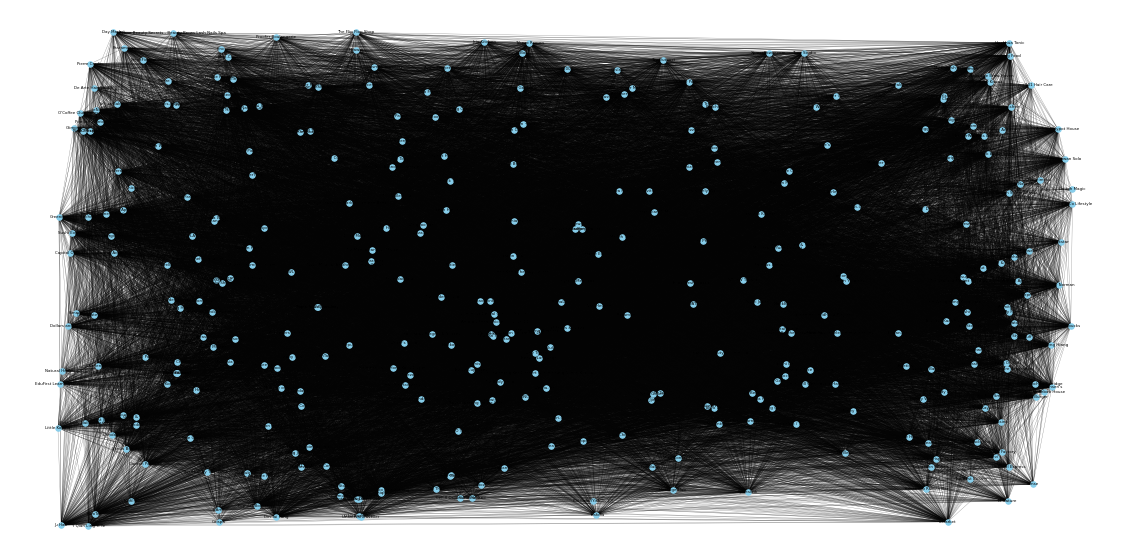

In [87]:
# can't see much - too many stores
# create Graph object using weighted store matrix as adjacency matrix
graph = nx.from_numpy_matrix(stores_weighted)
pos = nx.random_layout(graph) # position nodes uniformly at random
labels = {}
for idx, node in enumerate(graph.nodes()):
    labels[node] = purchase_binary.columns[idx]

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(graph, pos, node_color="skyblue", node_size=30)
nx.draw_networkx_edges(graph, pos, edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(graph, pos, labels, font_size=4)
plt.axis('off')
plt.show()

In [88]:
# community detection within graph, resolution changes size of the communities, default: 1
partition = community_louvain.best_partition(graph, resolution=0.85) 
values = list(partition.values())

In [89]:
print('Number of communities:', len(np.unique(values)))

Number of communities: 10


In [90]:
store_communities = pd.DataFrame(list(purchase_binary.columns), columns = ['Store Name'])
store_communities['community_id'] = values

In [91]:
store_communities.groupby('community_id').size()

community_id
0    55
1     6
2    21
3    16
4    44
5    35
6    45
7    32
8    40
9    61
dtype: int64

In [92]:
store_communities[store_communities['community_id'] == 1]

,Store Name,community_id
2,A.Track Apparels,1
12,Ban Heng Teochew Porridge,1
139,Jeju Kitchen,1
234,Poh Kim DVD Blu-Ray,1
308,The Pine Garden,1
338,Wing Joo Long,1


In [96]:
testo = store_communities[store_communities['community_id'] == 1]
testo

,Store Name,community_id
2,A.Track Apparels,1
12,Ban Heng Teochew Porridge,1
139,Jeju Kitchen,1
234,Poh Kim DVD Blu-Ray,1
308,The Pine Garden,1
338,Wing Joo Long,1


In [123]:
def recommend_com(store, n=5):
    """recommends up to n stores to visit next based on networkx community and frequencies of stores visited in train 
    data set after store input"""
    com = store_communities[store_communities['Store Name'] == store].iloc[0]['community_id']
    df_com = store_communities[store_communities['community_id'] == com]
    scores = {}
    for i in range(len(df_com)):
        to = df_com.iloc[i]['Store Name']
        if (to in nextstore[store]) & (to != store) :
            score = nextstore[store][to]
            scores[to] = score

    return dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5])

In [124]:
recommend_com('Jeju Kitchen')

{'The Pine Garden': 9.999962825417008,
 'Wing Joo Long': 9.999959839518715,
 'A.Track Apparels': 3.9999780220987797,
 'Poh Kim DVD Blu-Ray': 2.9999615389546284}

In [125]:
recommend_com('Innisfree')

{'Etude House': 26.9998836211913,
 'Hotwind': 16.99994568707449,
 'The Green Party': 9.999963636495865,
 'Krispy Kreme': 7.999968379571621,
 'Bata': 6.999975609841081}

In [126]:
recommend_com('Big Fish Small Fish')

{'Moley Apparels': 15.999897436554898,
 'Urban Write': 8.999956097775135,
 'Cotton On Kids': 7.9999666668055545,
 'Mei Heong Yuen Dessert': 3.999979166775173,
 'QB House Premium': 3.99997530879439}

## Evaluation: MAP@k

In [130]:
ap_at_k(['Innisfree'], recommend_com('Innisfree'))

1.0

In [141]:
len(purchase_binary.columns)

355

In [152]:
all_stores = purchase_binary.columns # that are within communities in the network/ in train data set - 355
sample = random.sample(list(all_stores), 100)

scores = 0.0
for i in range(len(sample)):
    store = sample[i]
    scores += ap_at_k([store], recommend_com(store))
print('MAP@5: {0:.3f}'.format(scores/len(sample)))

MAP@5: 0.970
